In [1]:
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnpå
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif

from desc.utils import cross, dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import FourierCurrentPotentialField

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray

from desc.fns_simp import (plot_figure,
                           plot_figure2,
                           plot_xy,
                           surf_int,
                           _compute_magnetic_field_from_Current)

from desc.finite_diff2 import (first_derivative_t, first_derivative_z,
                              )

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory

In [3]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

eq = eq_QA    
###
#surf_winding = load("/home/fcastro/LMStell/sigma/RQA/surf5/surf_opt_2.h5")

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

<class 'jaxlib.xla_extension.ArrayImpl'>

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

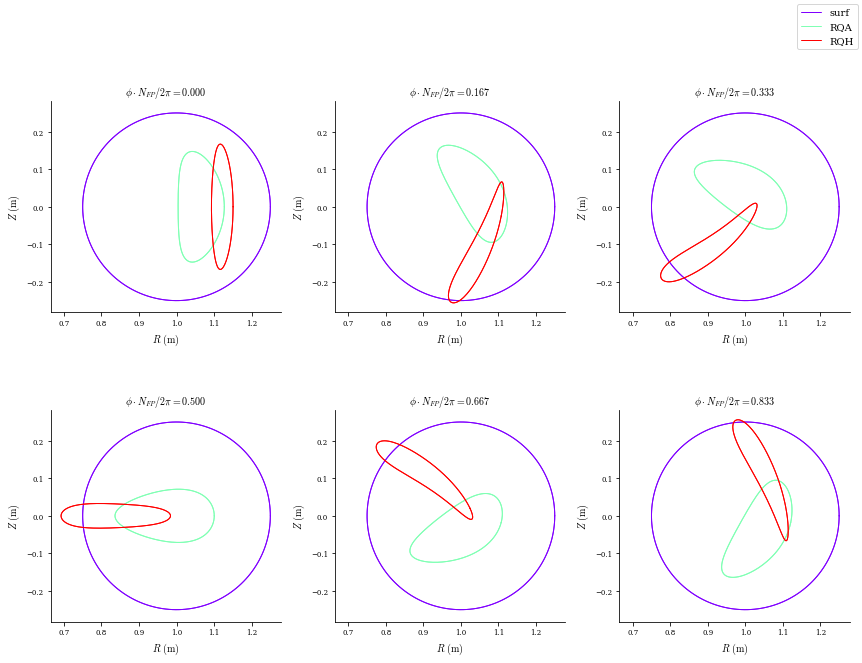

In [4]:
# Winding surface
a = 1
b = 0.25

surf_winding = FourierRZToroidalSurface(R_lmn=[a,b], 
                                Z_lmn=[-b],
                                modes_R=np.array([[0,0],[1,0]]),
                                modes_Z=np.array([[-1,0]]),
                                NFP=eq.NFP)

surf_winding.save("surf_0.h5")
# Find surface current K_s
winding_surf = FourierCurrentPotentialField.from_surface(surf_winding,
                                                                 )
# Plot both surfaces
plot_comparison([winding_surf,eq_QA,eq_QH],labels=["surf","RQA","RQH"],theta=0,rho=np.array(1.0))

In [5]:
egrid = LinearGrid(M = 60, 
                   N = 60, 
                   NFP = eq.NFP
                  )

edata = winding_surf.compute(["u_iso_torus","v_iso_torus",
                              "u_iso_t_torus","v_iso_t_torus",
                              "u_iso_z_torus","v_iso_z_torus",
                              "H_1_torus","H_2_torus",
                              "lambda_iso_torus",
                              "lambda_iso_u_torus","lambda_iso_v_torus",
                              "e_u_torus", "e_v_torus",
                              "phi_iso_torus",
                              "psi_iso_torus",
                              "Psi_iso_torus",
                              "b_iso_torus", "lambda_ratio_torus"
                             ], 
                             grid = egrid)

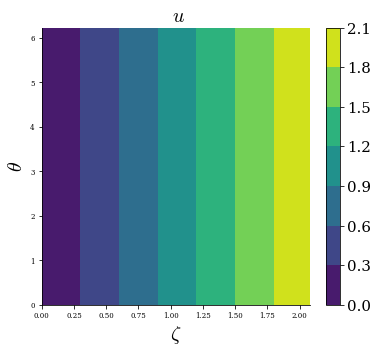

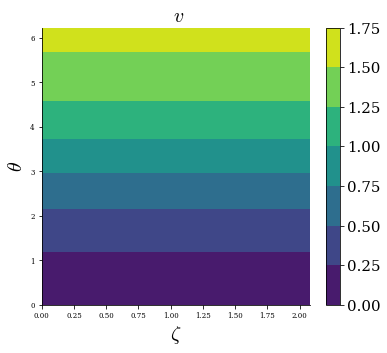

In [6]:
plot_figure2(edata["u_iso_torus"], egrid, ''r' $ u $ ')
plot_figure2(edata["v_iso_torus"], egrid, ''r' $ v $ ')

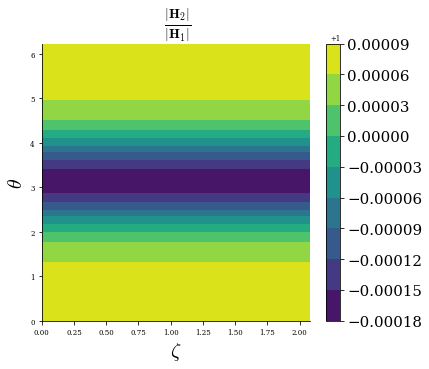

In [7]:
plot_figure2(dot(edata["H_2_torus"],edata["H_2_torus"])**(-1/2)*dot(edata["H_1_torus"],edata["H_1_torus"])**(1/2),
             egrid,
             ''r' $ \frac{| \mathbf{H}_2 |}{| \mathbf{H}_1 |} $ ')

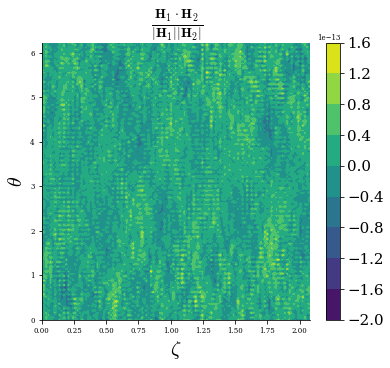

In [8]:
plot_figure2(dot(edata["H_1_torus"],edata["H_2_torus"]
                )*(
    dot(edata["H_1_torus"],edata["H_1_torus"])*dot(edata["H_2_torus"],edata["H_2_torus"])
)**(-1/2),
             egrid,
             ''r' $ \frac{ \mathbf{H}_1 \cdot \mathbf{H}_2 }{ | \mathbf{H}_1 | | \mathbf{H}_2 | }$ ')

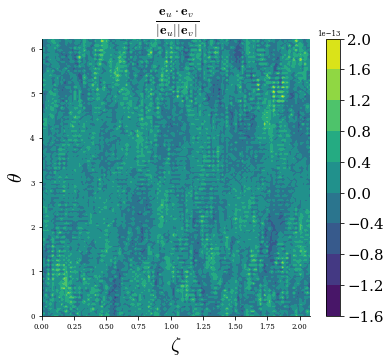

In [9]:
# Confirm that new basis vectors are perpendicular
plot_figure2(dot(edata["e_u_torus"],edata["e_v_torus"]
                )*(
    dot(edata["e_u_torus"],edata["e_u_torus"])*dot(edata["e_v_torus"],edata["e_v_torus"]))**(-1/2),
             egrid,
             ''r' $ \frac{ \mathbf{e}_u \cdot \mathbf{e}_v }{ | \mathbf{e}_u | | \mathbf{e}_v | }$ ')

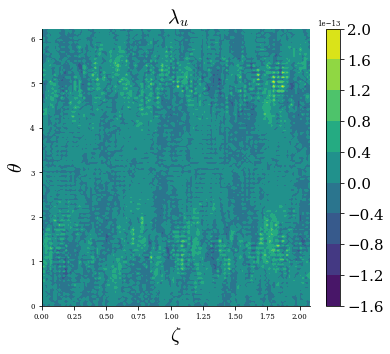

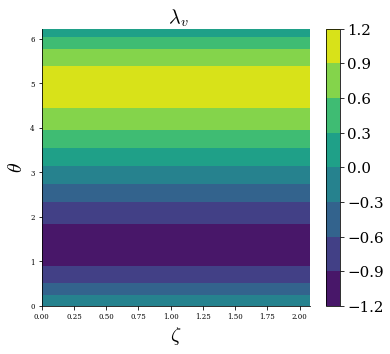

In [10]:
plot_figure2(edata["lambda_iso_u_torus"], egrid, ''r' $\lambda_u $ ')

plot_figure2(edata["lambda_iso_v_torus"], egrid, ''r' $\lambda_v $ ')

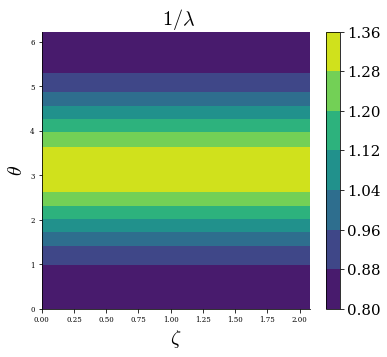

In [11]:
plot_figure2( 1 / edata["lambda_iso"], egrid, ''r' $1 / \lambda $ ')

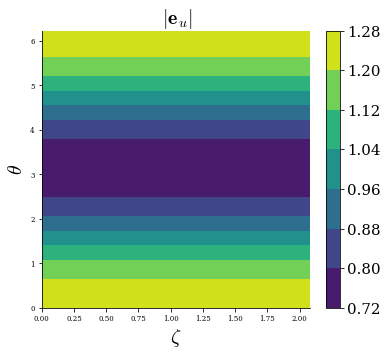

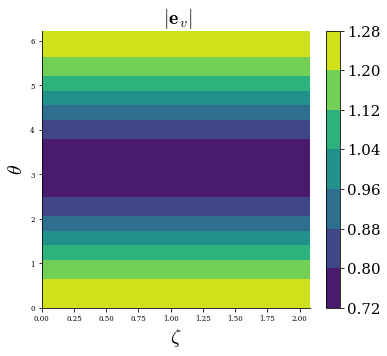

In [12]:
# Confirm that new basis vectors are perpendicular
plot_figure2( dot( edata["e_u_torus"], edata["e_u_torus"] ) ** (1/2), egrid, ''r' $ | \mathbf{e}_u |$ ')
plot_figure2( dot( edata["e_v_torus"], edata["e_v_torus"] ) ** (1/2), egrid, ''r' $ | \mathbf{e}_v |$ ')

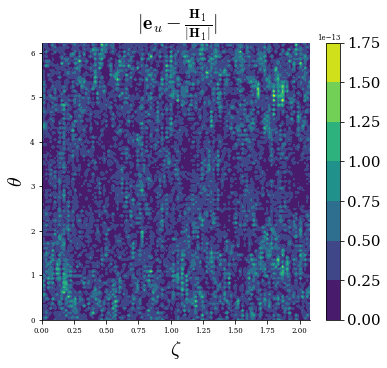

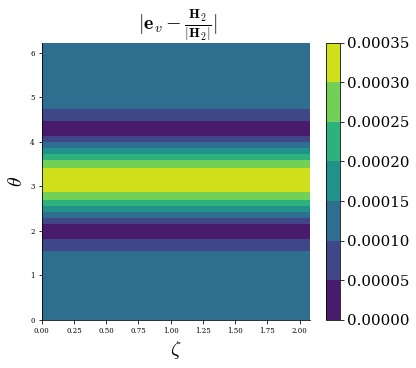

In [13]:
erroru = ( 1 / edata["lambda_iso_torus"] * edata["e_u_torus"].T - edata["lambda_iso_torus"] * edata["H_1_torus"].T ).T
errorv = ( 1 / edata["lambda_iso_torus"] * edata["e_v_torus"].T - edata["lambda_iso_torus"] * edata["H_2_torus"].T ).T

# Confirm that new basis vectors are perpendicular
plot_figure2( dot( erroru, erroru ) ** (1/2), egrid, 
             ''r' $ | \mathbf{e}_u - \frac{ \mathbf{H_1} }{ |\mathbf{H_1}| } |$ ')
plot_figure2( dot( errorv, errorv ) ** (1/2), egrid, 
             ''r' $| \mathbf{e}_v - \frac{ \mathbf{H_2} }{ |\mathbf{H_2}| } | $ ')

In [14]:
np.save('u',edata["u_iso_torus"])
np.save('v',edata["v_iso_torus"])

np.save('u_t',edata["u_iso_t_torus"])
np.save('v_t',edata["v_iso_t_torus"])

np.save('u_z',edata["u_iso_z_torus"])
np.save('v_z',edata["v_iso_z_torus"])

np.save('lambda_u',edata["lambda_iso_u_torus"])
np.save('lambda_v',edata["lambda_iso_v_torus"])

np.save('Phi',edata["phi_iso_torus"])

np.save('psi',edata["psi_iso_torus"])
np.save('Psi',edata["Psi_iso_torus"])
np.save('b',edata["b_iso_torus"])
np.save('ratio',edata["lambda_ratio_torus"])